### Import Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

### Fit and run RF model on 2022-23 season. Using a random sample to split and training on 70% of the data.

In [2]:
df = pd.read_csv('exports/processed_gamelogs_top200_ppg_season22_23.csv')
df['date_dt'] = pd.to_datetime(df['date_dt'])

In [3]:
# Drop uneeded columns and set the index.
data = df.drop(columns=['home_vs_away', 'wl'], inplace=False)

data.set_index(['player_name', 'date_dt'], inplace=True)

# Shift cols to remove lookahead bias
data['pts'] = data['pts'].shift(1)
data['pts_10'] = data['pts_10'].shift(1)
data['pts_5'] = data['pts_5'].shift(1)
data['pts_3'] = data['pts_3'].shift(1)
data['pts_last'] = data['pts'].shift(2)

data = data.dropna()

In [4]:
# Define features and target
X = data[['pts_10', 'pts_5', 'pts_3', 'pts_season', 'pts_last']]
y = data['pts']

# Split data into training and testing sets randomly
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the Random Forest model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


# Evaluate model, we'll use MAE to start under the assumption that we'll have significant outliers.
predictions = model.predict(X_test)
print("MAE:", round(mean_absolute_error(y_test, predictions), 4))

# Create a results df that aligns with the test set
results = X_test.copy()  
results['pts'] = y_test  
results['predicted'] = predictions 
results['error'] = abs(results['pts'] - results['predicted']).astype('int')

MAE: 4.339


### Optimizing params with grid search.

In [5]:
# Defining param grid 
param_grid = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10]
}

# Creating a random forest regressor object
rf_regressor = RandomForestRegressor(random_state=24)

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(rf_regressor, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

# Getting the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score (MAE):", best_score.round(3))

Best Parameters: {'max_depth': 5, 'n_estimators': 500}
Best Score (MAE): 4.234


In [6]:
# Fit the model using the grid search results as params.
rf_regressor_best = RandomForestRegressor(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=42)
rf_regressor_best.fit(X_train, y_train)

# Fetch predictions
predictions = rf_regressor_best.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print("MAE:", round(mae, 3))

MAE: 4.185


#### Check results.

In [7]:
# Create a results df that aligns with the test set
results = X_test.copy()  
results['pts'] = y_test  
results['predicted'] = predictions.round(2) 
results['error'] = abs(results['pts'] - results['predicted']).astype('int')

# Print the results, ordering by predictions with the largest error. Also use descbribe to better understand the distribution.
display('Results sorted by largest error:', results[['pts', 'predicted', 'error']].sort_values(by='error', ascending=False).head(10), results[['pts', 'predicted', 'error']].describe())

'Results sorted by largest error:'

,,pts,predicted,error
player_name,date_dt,,,
Brandon Boston,2023-01-26,0.0,22.44,22
Bennedict Mathurin,2023-03-20,57.0,35.78,21
Malik Beasley,2022-12-02,17.0,35.58,18
Isaiah Joe,2022-12-16,10.0,27.30,17
P.J. Washington,2023-01-16,33.0,15.69,17
Onyeka Okongwu,2022-12-12,1.0,18.84,17
Derrick White,2023-02-14,33.0,15.53,17
DeMar DeRozan,2022-11-16,2.0,19.19,17
Cam Thomas,2022-12-02,14.0,31.08,17


,pts,predicted,error
count,2812.000000,2812.000000,2812.000000
mean,15.715149,15.697528,3.705548
std,9.438464,7.864189,3.297002
min,0.000000,0.620000,0.000000
25%,8.000000,10.470000,1.000000
50%,15.000000,14.860000,3.000000
75%,22.000000,21.440000,5.000000
max,57.000000,40.480000,22.000000


### Display feature importance.

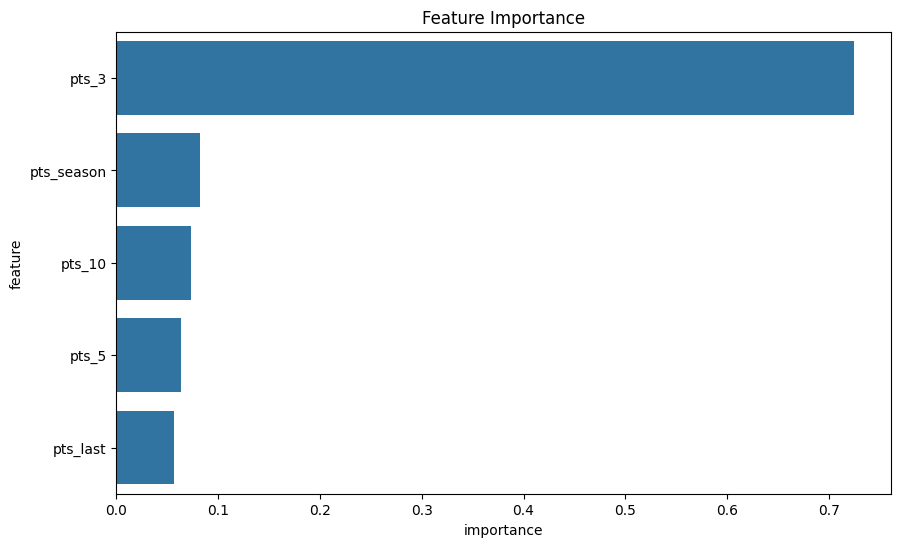

      feature  importance
2       pts_3    0.725136
3  pts_season    0.081712
0      pts_10    0.073707
1       pts_5    0.063262
4    pts_last    0.056184


In [8]:
importances = model.feature_importances_
feature_names = X_train.columns

# Create a df for easy visualization
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
})

# Sort the df by importance
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

print(importance_df)


### Visualize predicted vs actual values.

C:\Users\mjgdr\AppData\Local\Temp\ipykernel_3092\1940108770.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


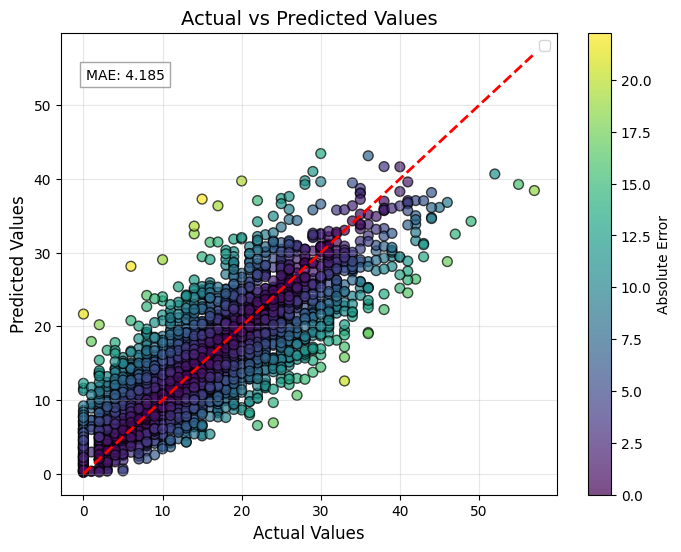

In [9]:
# Predictions and errors
predictions = model.predict(X_test)
errors = np.abs(predictions - y_test)

# Create a scatter plot
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    y_test, predictions, 
    c=errors, cmap='viridis', alpha=0.7, edgecolor='k', s=50
)

plt.colorbar(sc, label='Absolute Error') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         color='red', linestyle='--', linewidth=2) # label='Perfect Predictions'
         
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.title("Actual vs Predicted Values", fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Annotate metrics on the plot
plt.text(
    0.05, 0.9, 
    f"MAE: {round(mae, 3)}", 
    transform=plt.gca().transAxes, fontsize=10, 
    bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
)

plt.show()
